# 2. Managing Missing Data

<span style="font-size:14px;font-family: Arial;line-height:1.5">
Having looked at the data in chapter 1, we can see that some variables of interest such as Age are sometimes missing from the ~20% of the dataset. Our exploration also hinted that this information could be a valuable predictor for whether someone survived and so we might be heavily incentivised to use that feature. <br>

In this chapter, we'll answer three questions that are central to any data analysis:
1. What is missing?
2. Why is it missing?
3. What are we going to do about it?

Several methods for dealing with missing data exist, either using simple summary statistics or by devising more complex models for predicting missing values based on remaining features that are available. We'll also cover some statistical models that can handle missing data as part of the input, and what benefits that might offer.

We'll load the data after the initial review and cleaning that took place in Chapter 1.

In [1]:
from pathlib import Path
import pandas as pd

data_dir = Path.cwd().parent / 'data/original'        
train = pd.read_csv(data_dir / 'train.csv')
test = pd.read_csv(data_dir / 'test.csv')

print(f"Training data = {train.shape[0]} passengers")
print(f"Test data = {test.shape[0]} passengers")

Training data = 891 passengers
Test data = 418 passengers


## 2.1. What's missing?

<span style="font-size:14px;font-family: Arial;line-height:1.5">
In their book <i>Statistical Analysis with Missing Data</i> (3rd Edition, 2020), Little and Rubin distinguish between the patterns of missing data and the mechanisms of missing data. This distinction highlights that it's important to understand where and when data is missing, but also the reasons why data is absent. 
</span>

### 2.1.1. Which columns have missing data
<span style="font-size:14px;font-family: Arial;line-height:1.5">
For a simple dataset like the titanic files, where each column is supposed to be a distinct measurement, we can start by simply asking which columns have missing data in each dataset. Although methods such as describe() offer an way to identify columns with missing data, the output can be messy when there are a lot of columns, most of which have complete data. For that reason, I decided to write a quick function summarizing only those columns with missing data:
</span>

In [2]:
def report_columns_missing_data(df, label:str):

    return (
        pd.DataFrame(
            df.isna().sum()
            )
        .rename({0:label}, axis=1)
        .query(f"{label} > 0")
    )

# Report missing data for both test and train datasets
pd.concat(
    (
        report_columns_missing_data(train, 'train'),
        report_columns_missing_data(test, 'test')
    ), 
    axis=1).fillna(0)

,train,test
Age,177.0,86.0
Cabin,687.0,327.0
Embarked,2.0,0.0
Fare,0.0,1.0


<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
We have missing rows for <i>Age</i> and <i>Cabin</i> in both test and train data, but we also have rare cases where the port of embarcation (<i>Embarked</i>) is missing from the training data and the <i>Fare</i> paid by one passenger is missing form the test dataset. One can also view the missing Surivival values in the test set as missing data, and thus the goal of the project of predicting survival can be viewed as an imputation problem.
<p>
<img src="./../img/missing_data.png" alt="Tabular data shown as rectangles with missing sections indicating missing data" width="500">
</p>
<br></br>
Leaving aside this perspective for the moment (we will get back to this in Chapter ???),  we can see how the pattern of missing data shapes our approach to model design. Either we ignore Age and Cabin, or we develop a strategy to deal with missing values. If the test data contained only complete-cases (i.e. no missing data), we could potentially remove those passengers with missing ages or cabins from the dataset and train our model on data from passengers without missing data. 

### 2.1.2. Complete case analysis: Why impute rather than delete?
<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
In complete case analysis, we drop any rows or columns that contain missing data. This method is simple and easy to implement, but has several problems:   
<br>(1) Dropping cases is inefficient as we reduce the number of data points we can use for model fitting, and we lose statistical power with the reduced sample size.
<br>(2) Dropping missing data may bias the results if the missing data is not missing completely at random. (Consider the case where age data is missing specifically from passengers that perished)
<br>(3) Dropping cases with missing data doesn't provide a useful strategy for making predictions on new test data that contains missing values. If we just delete missing data, then either we can't base predictions a feature that contains missing data (which is highly undesirable) or we have to skip test cases where data is missing (which will hurt performance badly).
<br>(4) From a practical perspective, dropping cases with missing data may be expensive if we're spending resources to collect data. 
</p><p>
In the titanic dataset, we have so many cases of missing cabin data that to limit ourselves to a complete case analysis would reduces the size of our training set dramatically. We also have good reason to believe that features like Age and Deck (a transform from Cabin) are associated with survival (see Chapter 1) and so we definitely want to include them in the model. For the reasons above, we will avoid removing missing data. 
</p>


### 2.1.3. What denotes a missing value - NaN vs. Numbers?
<p>
In the code that summarises missing data above, we're assuming that missing values are coded as NaNs, but that might not always be the case. Sometimes  data acqusition systems will return values out of range or zeros. Numeric coding can be a major issue when those responsible for the data collection use zeros or other values, as it distorts the distribution of data while simultaneously masking missing data. It's therefore always worth looking out impossible numbers or inflated counts at specific numbers.  
</p><p>
In the titanic dataset, we have already identified the zero fares as one example of this probelm (Chapter 1.2.4). We also noted that within several string variables (e.g. Name and Ticket) we can extract information for some passengers, but that is missing for others. In these cases, missing information may be encoded as an empty string ('') rather than NaNs.
</p>
</span>

## 2.2. Why is data missing?
<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
Data may be missing for a specific reason, sometimes called the "missingness mechanism". For example if Age and Cabin data was collected from survivors. Those that perished would not have been available to provide the information. We call such data missing not at random (MNAR) and it can be substantially  <b>biased</b>. 
</p><p>
If data is MNAR, then the fact that a datapoint is missing can be informative. Below we explore why data is missing from the titanic dataset and consider how that might help us predict survival. To help us, we're going to bring back some of the features we extracted in Chapter 1:
</p></span>

In [3]:
data_dir = Path.cwd().parent / 'data/chapter_1'        

train = pd.read_csv(data_dir / 'train_Ch01.csv')
test = pd.read_csv(data_dir / 'test_Ch01.csv')

print(train.columns.to_numpy())

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked' 'age_measure' 'age_group' 'log_fare'
 'people_on_ticket' 'ticket_num' 'ticket_prefix' 'no_ticket_prefix'
 'n_rooms' 'Deck' 'Surname' 'Title' 'professional_title' 'nob_title'
 'family_size']


### 2.2.1. Zero Fares: Passengers as Employees
<span style="font-size:14px;font-family: Arial;line-height:1.5">
Why would someone pay nothing for a ticket on the most luxurious ship in the world? The obvious first answer is the people who sail the ship, but sailors are not part of the passenger list. Maybe there's something in the data that can shed light on who these passengers might be:
</span>

In [4]:
(
    pd.concat([
        train[train['Fare'] == 0.0],
        train[train['Fare'].isna()],
        test[test['Fare'] == 0.0],           # test data indicated by Survived=NaN
        test[test['Fare'].isna()]
    ])
    .sort_values(by='Name')
    .filter(['Name','Age','Sex','Pclass','Ticket','n_rooms'])
)

,Name,Age,Sex,Pclass,Ticket,n_rooms
837,"Andrews, Mr. Thomas Jr",39.0,male,1,112050,1
388,"Campbell, Mr. William",NaN,male,2,239853,1
266,"Chisholm, Mr. Roderick Robert Crispin",NaN,male,1,112051,1
387,"Cunningham, Mr. Alfred Fleming",NaN,male,2,239853,1
592,"Frost, Mr. Anthony Wood ""Archie""",NaN,male,2,239854,1
843,"Fry, Mr. Richard",NaN,male,1,112058,1
366,"Harrison, Mr. William",40.0,male,1,112059,1
372,"Ismay, Mr. Joseph Bruce",49.0,male,1,112058,3
269,"Johnson, Mr. Alfred",49.0,male,3,LINE,1
268,"Johnson, Mr. William Cahoone Jr",19.0,male,3,LINE,1


<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>If you have background knowledge about the titanic disater, or you've watched the James Cameron film, then some of those names might pop out at you. In particular, <b>Mr Joseph Ismay</b> - a man who paid nothing but had three cabins - what's going on there? Well, he was the managing director of White Star Lines, the company that owned the ship. It's therefore not surprising that he didn't pay to travel, or that he got several rooms. Also listed is <b>Mr Thomas Andrews</b>, the chief designer of the ship and one of the "<b>Titanic Guarentee Group</b>" - a team of 10 engineers sent by the shipbuilders Harland & Wolff to accompany the maiden voyage. Of the 10 in the group, 9 are listed above, while the 10th (Joseph Thompson) disembarked at Southamptom and is not in the dataset.
</p><p>
What about others - could they also be employees? Every zero-fare individual was male, and given that few women were in the workforce in 1912, it makes it more viable that all these individuals had some relevant profession. Indeed, external research confirms that several men identified above (William Tornquist, William Cahoone Johnson Jr., Alfred Johnson, and Lionel Leonard) were being transported by their employer (<b>American Line</b>). It therefore seems reasonable to summerise that people on zero fares represent a specialty group.
</p><p>
The zero values used to mark these passengers may distort the relationship between Fare and Surival, or other variables by reducing the average fare of those who did not survive. We should therefore mask these zero values with nans so that we can then impute appropriate missing values in Section 2.3.
</p><p>
<i>Notes:
    <li>Here we are introducing more missing values than we had originally, but now the fare data makes more sense.</li>
    <li>In the log-transformed fare (log_fare) created in Chapter 1.2.4, we already removed zero values as a pre-requisite for the log transform</li>
    <li>Flagging zero-fares as missing will allow us to use graphical methods later on in (CHAPTER?) to ask "what would these passengers pay if they had to buy their own tickets"
</i>
</p></span>

In [5]:
train['Fare'] = train['Fare'].mask(train['Fare'] == 0)
test['Fare'] = test['Fare'].mask(test['Fare'] == 0)

<span style="font-size:14px;font-family: Arial;line-height:1.5">

Passengers who paid nothing had a very low survival rate (1/15) in the training data. This suggest that anyone in the category was very likely to go down with the ship. A column indicating the special status of zero fare passengers is thus likely to be useful in predicting surival in the test set.
</span>


In [6]:
train['zero_fare'] = train['Fare'].isna()
test['zero_fare'] = test['Fare'].isna()

### 2.2.2. Who is Mrs Stone? The case of missing embarcation
<span style="font-size:14px;font-family: Arial;line-height:1.5">
In the training data, there are two cases of missing embracation information. There is no embarcation data missing in the test data. Who are these passengers and is there any reason their point of embarcation is unknown?
</span>

In [7]:
train.loc[train[train.Embarked.isna()].index, ['Name','Age','Sex','Cabin','Pclass','Fare','SibSp','Parch']]

,Name,Age,Sex,Cabin,Pclass,Fare,SibSp,Parch
108,"Icard, Miss. Amelie",38.0,female,B28,1,80.0,0,0
109,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0,female,B28,1,80.0,0,0


<span style="font-size:14px;font-family: Arial;line-height:1.5">
These two women appear to be travelling on the same ticket staying in the same first class cabin, with no direct relatives in either case. Is anyone else travelling on that ticket, or staying in that Cabin?
</span>

In [8]:
ticket_no = "113572"
cabin_no = "B28"

idx = train[(train['Ticket'].str.match(ticket_no)) | (train['Cabin'].str.match(cabin_no))].index
train.loc[idx, ['Name','Age','Sex','Cabin','Pclass','Fare','SibSp','Parch']]

,Name,Age,Sex,Cabin,Pclass,Fare,SibSp,Parch
108,"Icard, Miss. Amelie",38.0,female,B28,1,80.0,0,0
109,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0,female,B28,1,80.0,0,0


<span style="font-size:14px;font-family: Arial;line-height:1.5">
No, doesn't look like it. This is where outside research can help... Looking up the Amelie Icard, we discover that she was a maid for Mrs Stone and that both embarked at Southampton. We will add this data specifically to these records here:
</span>

In [9]:
train['Embarked'].fillna('S', inplace=True)

<span style="font-size:14px;font-family: Arial;line-height:1.5">
This outside research allows us to fill in the missing data but it also reveals something important about the dataset: <i>there is information about connections between passengers available in ticket data that aren't represented by family relationships (i.e. surnames, Parch or SibSp)</i>.

</span>

### 2.2.3. Missing Age Data
<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>We noted in Chapter 1.2.1. that age data might be missing because passengers did not surivive. While it is true that the average survival rate is substantially lower in cases where age is missing, there are still 30% of passengers who survive but have no age data. Could these be, for example, children who have lost a parent and don't know their age?
</p><p>
Let's find out by testing a hypothesis: If children are more likely to be missing Age data, then we might expect there to be more passengers with the title 'Master' missing Age data in the survivors than in those passengers lost. (Note here that I'm using the 'Master' title rather than 'Miss' due to the potential confound of unmaried women that results from naming conventions of the time). To test this hypothesis, we can run a simple Chi-squared test:
</p></span>

In [10]:
train['age_missing'] = train['Age'].isna()
test['age_missing'] = test['Age'].isna()

In [11]:
from scipy.stats import chi2_contingency

chisq_data = (
    train
    .query("Title == 'Master'")            # Noted Bug: White space in titles
    .groupby(['age_missing','Survived'])
    .agg({'PassengerId':['count']})
    .reset_index()
    .pivot(columns='Survived', index='age_missing')
)

print('Contingency table')
print(chisq_data)

chi2, p, dof, expected = chi2_contingency(chisq_data.values) 
print(f"Chi-squared test that observations deviate from expectations: {dof} d.f. Chi-squared = {chi2}, p = {p}")

Contingency table
            PassengerId    
                  count    
Survived              0   1
age_missing                
False                15  21
True                  2   2
Chi-squared test that observations deviate from expectations: 1 d.f. Chi-squared = 0.0, p = 1.0


<span style="font-size:14px;font-family: Arial;line-height:1.5">
These results suggest our hypothesis was wrong - passengers without cabin data aren't any more likely to be missing data when surviving. (The same is true if we look at passengers with 'Miss' as title). For the moment at least, it remains unclear why Age is missing for these passengers (and we must acknowledge that there may not be a reason).
</span>

### 2.2.4. Cabins
<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>The largest amount of missing data comes from the Cabin column, where there are fewer datapoints than there are NaN values. Why is this data absent when presumably everyone had a room? 
</p><p>
In Chapter 1, we discussed how the organization of the ship tells us something about how Cabins were assigned, with first class passengers in Decks A-E, second class passengers in D through F and third class in Decks E to G. There are also differences in Fare between Decks and at least some instances where Cabin information is available for other passengers travelling on the same ticket. All these pieces of information may help us impute the Deck of the ship in which passengers were staying, even if we can't recover the actual room. 
</p><p>
If we look at the outcomes for those with Cabin information present, they are fare more likely to survive. This suggests a sampling bias in which cabin information was recovered predominatly from surivors. It's important to note that this bias isn't a hard rule, as there were some people for whom Cabin data is available and didn't survive, and vice versa.</p></span>

In [12]:
train['cabin_missing'] = train['Cabin'].isna()
test['cabin_missing'] = test['Cabin'].isna()

In [13]:
(
    train
    .groupby('cabin_missing')
    .agg({'Survived':['count', 'sum', 'mean'],})
)

Survived               
                 count  sum      mean
cabin_missing                        
False              204  136  0.666667
True               687  206  0.299854

In [14]:
# gender_map = {'male':0,'female':1}
# train['gender_numeric'] = train['Sex'].map(gender_map)
# test['gender_numeric'] = test['Sex'].map(gender_map)

# embark_map = {'C':1,'Q':2,'S':3}
# train['embarked_numeric'] = train['Embarked'].map(embark_map)
# test['embarked_numeric'] = test['Embarked'].map(embark_map)

## 2.3. Single Imputation Methods: 

### 2.3.1. Mean, median or mode
<span style="font-size:14px;font-family: Arial;line-height:1.5">
 This involves replacing the missing data with the mean or median value of the non-missing data in the same column. 

<br><b>Advantages</b><br> 
 
 Useful to generate placeholder values if the missing data is missing at random and if the data is normally distributed.

<b>Disadvantages</b><br>

Mean imputation leads to the sample variance of the filled-in data underestimating the true variance by a factor proportional to the percentage of missing data. Imputation also distorts the empirical (observed) distribution of the data, which is reflected in metrics such as percentiles. Mean imputation also leads to underestimates in covariance, which can affect our ability to use a variety of modelling approaches that involve covariance matrices (e.g. correlation).
 
If the data is not normally distributed or if the missing data is not missing at random, single imputation may also potentially introduce bias. The same is true if there are group differences in means that are ignored during imputation, such as using the global mean Age when the average age of first class passengers is greater than third class passengers.
</span>


In [15]:
# Replace with mean 
# train.fillna(train.mean(), inplace=True)
# test.fillna(test.mean(), inplace=True)

# Replace with median 
# train.fillna(train.mean(), inplace=True)
# test.fillna(test.mean(), inplace=True)

### 2.3.2. Conditional Mean Imputation

<span style="font-size:14px;font-family: Arial;line-height:1.5">
Divide data up into classes within which one can then take the mean and apply it to all missing observations in the same class. For example, we could group passengers by Gender and PClass and impute the mean age for each separately. The code shows one way to do this, though the method still underestimates that sample variance and has many of the same weaknesses as mean imputation discussed above. For that reason, we leave the actual function call commented out.
</span>

In [16]:
def impute_conditional_mean(df, impute_column, adjustment_columns):
    """ 
    Args:
        df: dataframe containing missing values and grouping variables
        impute_column: column containing missing data
        adjustment_columns: columns containing classes used to compute means separately 

    Returns
        df: dataframe with missing values impute
     """

    for adjustment_class, class_data in df.groupby(adjustment_columns):
        
        idx = class_data[class_data[impute_column].isna()].index
        df.loc[idx, impute_column] = class_data[impute_column].mean()

    return df

# train = impute_conditional_mean(train, impute_column='Age', adjustment_columns=['Sex','Pclass'])
# test = impute_conditional_mean(test, impute_column='Age', adjustment_columns=['Sex','Pclass'])

### 2.3.3. Regression Imputation

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
This involves using a regression model to predict the missing values based on the non-missing values in the same row or other relevant variables. This can be useful if the missing data is not missing at random and if there are strong relationships between the missing and non-missing values. However, it can also introduce bias and error if the regression model is misspecified or features are not correlated.
</p><p>
Let's first examine the correlations between age and other features. 
</p><p>
<i>Notes : 
<p style="margin-left: 40px">
    - The .corr() function can only work with numeric data and so to examine the role of categorical variables, we replace strings with numbers.<br>
    - Converting categorical to numeric data using the map() method with a specified dictionary makes the coding of variables explicit and the numeric values easier to interpret.<br>
    - Mapping in this way also ensures consistency between parallel operations on test and train datasets, while also ensuring that any future values of the source feature that aren't in the map do not receive values.<br>
    -  Replacement for titles is a bit complicated as we assume people with Master/Miss in their name will probably be younger than those with Mr or Mrs in their name. At the same time, we also might anticipate that those with professional (Dr, Major etc) or noble titles (Sir, Lady etc.) are likely to be older than the average Mr/Mrs.<br>
</p>
</i></p></span>

<AxesSubplot: >

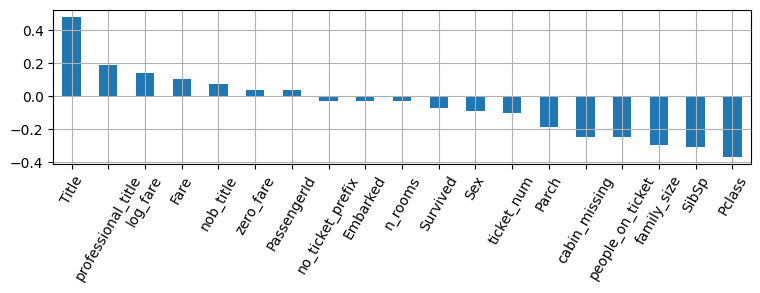

In [17]:
# Code titles depending on age (Miss/Master=0, Mr/Mrs=1, Other=2)
title_map = {k:(0 if k in ('Miss','Master') else (1 if k in ('Mr','Mrs') else 2)) for k in train['Title'].unique()}

(
    train
    .replace({                                  # Convert categories to numbers
        'Sex': {'male':0,'female':1},
        'Embarked': {'C':1,'Q':2,'S':3},
        'Title': title_map                      # Flag junior titles
    })
    .corr(numeric_only=True)['Age']             # Compute correlation matrix between features and return correlations with age
    .drop(['Age','age_group','age_missing'])    # Ignore autocorrelation and features based on age
    .sort_values(ascending=False)                      
).plot(
    kind='bar',
    figsize=(9,2),
    rot=60,
    grid=True
    )

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
As we would expect, the strongest correlation with age is with title, as those passengers with Master and Miss tend to be younger. We can also see a relatively strong negative correlation with class, reflecting the fact that older passengers tend to be more likely to travel in first class. We might also be unsurprised that number of siblings/partners is negatively correlated with age, as one is most likely to travel with siblings when younger. Fortunately, all these features are fully present, making them straightforward to use in a regression model.
</p><p>
The correlation results suggest we might have a chance of building a regression model for imputation. Let's give it a shot using a numeric version of title, passenger class and number of siblings / partners (SibSp) as predictors. First, we'll select the data used to train the model for which we have complete cases for predictors and the response variable (Age) that we're trying to impute.
</p>
</span>

In [18]:
predictors = ['Title','Pclass','SibSp']
response = ['Age']

model_data = (
    train[predictors + response]
    .dropna()
    .replace({'Title':title_map})       # Convert title categories to 0 (Master/Miss) or 1 (any other)
)

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
Next we'll use statsmodels to fit the linear regression. 
</p><p><i>
Note:
<li>Statsmodels has a few more tools for inspecting model fit than sklearn, and I like the R-style formula notation</li>
<li>The formula notation would also allow us to include categorical variables like title without formatting if we wanted (just replace 'Title' with 'C(Title)')</li>
<li>For simplicity, we'll just fit the main effects for the models below and ignore interactions, though they might be interesting to include</li>
</i></p></span>

In [19]:
import statsmodels.formula.api as smf

formula = 'Age ~ Title + Pclass + SibSp'
model = smf.ols(formula=formula, data = model_data)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     144.9
Date:                Tue, 24 Jan 2023   Prob (F-statistic):           3.01e-73
Time:                        20:48:42   Log-Likelihood:                -2752.7
No. Observations:                 714   AIC:                             5513.
Df Residuals:                     710   BIC:                             5532.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5038      1.475     23.385      0.0

<span style="font-size:14px;font-family: Arial;line-height:1.5">
We won't go through the whole model checking process that is good practice for fitting linear regressions, but the summary shows that each of the variables included in the model is contributing. This is confirmed by the similarity between r-squared and adjusted r-squared. If we assume for the moment that this model is helpful, then we can use it to predict missing age data:
</span>

In [20]:
impute_data = (
    train[predictors+response]
    .query(f"{response[0]}.isna()")   
    .replace({'Title':title_map})    
)

impute_data[response[0]+'_linear_pred'] = res.predict(exog=impute_data[predictors])
impute_data.describe(percentiles=[0.5])['Age_linear_pred']          # Show a quick summary'

count    177.000000
mean      27.577772
std       10.011991
min       -6.250276
50%       29.666293
max       53.595937
Name: Age_linear_pred, dtype: float64

<span style="font-size:14px;font-family: Arial;line-height:1.5">
We can see immediately from the summary that there are some problems, as we're predicting negative ages for some subjects. This indicates that the linear regression might not be the best type of model to use. We might therefore do better if we think about Age as count data (i.e. how many years or days has someone been alive) and instead use a poisson regression that provides a more appropriate approach for non-negative data.
</span>

In [21]:
import statsmodels.api as sm

poisson_model = smf.glm(formula=formula, data=model_data, family=sm.families.Poisson())
poisson_res = poisson_model.fit()

poisson_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Age   No. Observations:                  714
Model:                            GLM   Df Residuals:                      710
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3548.7
Date:                Tue, 24 Jan 2023   Deviance:                       3494.6
Time:                        20:48:42   Pearson chi2:                 3.35e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9436
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5151      0.024    147.100      0.000       3.468       3.562
Title          0.4311      0.015     28.924      0.000       0.402       0.460
Pclass        -0.1894      0.008    -23.589      0.000      -0.205      -0.174
SibSp         -0.1657      0.010    -16.704      0.000      -0.185      -0.146
==============================================================================
"""

<span style="font-size:14px;font-family: Arial;line-height:1.5">
A poisson regression is one form of the broader set of generalized linear models that provide useful methods when the linear regression isn't appropriate. This makes them very useful, but the interpretation of model fit and properties are in some cases more complex or less clear cut. We won't go into those issues here, but the output looks sufficiently sensible for us to proceed with imputation...
</span>

In [22]:
impute_data[response[0]+'_poisson_pred'] = poisson_res.predict(exog=impute_data[predictors])
impute_data.describe(percentiles=[0.5])['Age_poisson_pred']          # Show a quick summary

count    177.000000
mean      28.110973
std        9.206413
min        5.058009
50%       29.314367
max       65.885837
Name: Age_poisson_pred, dtype: float64

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
Now we see that our predictions are making more sense, as we no longer have negative values being imputed. A quick visual comparison shows that the overall outcomes are not that different, and we are tending to predict a lot of similar values near the mean age...
</p></span>

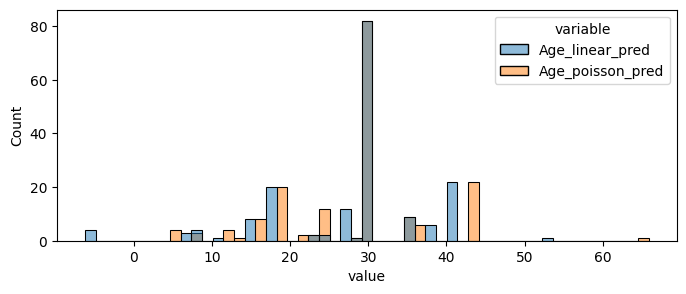

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1, **{'figsize':(8,3)})

sns.histplot(
    data = impute_data[['Age_linear_pred','Age_poisson_pred']].melt(),
    x = 'value',
    hue='variable',
    ax=ax
)
plt.show()

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
<b>Disadvantages of the regression method</b>
</p><p>
Although regression approaches are more sophisticated than basic mean or median imputation, it is important to say that regression predictions are still draws from the center of a distribution. This means that we will always predict the same age for a fixed set of predictors (e.g. a third class passenger whose name begins 'Master' and has 4 siblings), when in reality, we know that passengers with the same metadata may vary somewhat. This sampling approach that does not account for this uncertainty will thus continue to systematically underestimate variability. 
</p><p>
As Little and Rubin (2020) state "single imputation cannot reflect sampling variability under one model for missingness or uncertainty about the correct model for missingness". This prevents us from assessing how sensitive subsequent analysis is to different theories about why data is missing. 
</p>


### 2.3.4. Stochastic Regression Imputation

A random residual is added 

https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression/notebook


</span>


## 2.4. "Hot Deck" methods: Draws based on implicit models
<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
Hot deck imputation is a method for handling missing data in which each missing value is replaced with an observed response from a “similar” unit (<a href="http:\\www.ncbi.nlm.nih.gov/pmc/articles/PMC3130338">Andrige & Little, 2011</a>). Hot deck methods thus tend to draw from the same dataset (e.g. other passengers on the titanic), which can be contrasted with 'cold-deck' procedures in which samples are drawn from other data sources (e.g. passengers on other ships, or past sailings - if the titanic hadn't been on it's maiden voyage).
</p><p>
Here we will primarily consider what are sometimes called <i>random hot deck methods</i>, as they involve randomly selecting a donor value from a set of potential donors. This can be contrasted with <i>deterministic</i> hot deck methods that involve identification of a single donor.
</p><p>
<b>Advantages</b>
</p><p>
"Unlike mean imputation, the distribution of the sampled values of Y is not distorted by the imputations." (Little and Rubin, 2019). Sampling <i>with</i> replacement leads to additional sample variance, which can be reduced by sampling <i>without</i> replacement. 
</p><p>
Another advantage is that, unlike regression, you don't need to worry about model specification and draws from the available data will always been in a sensible range (i.e. no negative ages).
</p>
</span>

<span style="font-size:14px;font-family: Arial;line-height:1.5">


### 2.4.1. Hot-deck sampling with adjustment cells 

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
We might have good reason to believe that a variable with missing data is dependent on other features in the data. For example if female passengers tended to be older than male passengers. It may therefore be useful to resample data specifically from the most relevant data - i.e. if we have a missing age value for a male passenger, we resample from the available ages for only men. This organization of the dataset is sometimes called <i>stratification</i> and the groups of data created by stratifying are sometimes called <i>adjustment cells</i>.
</p><p>
Unfortunately there aren't many packages in Python for these approaches (to my knowledge); however it is quite straightforward to write our own.
</p>
</span>

In [24]:
from typing import List

def impute_with_adjustment_cells(df:pd.DataFrame, colname:str, strata:List[str], n_impute:int=1) -> pd.DataFrame:
    """ 
    Impute missing data by hot-deck resampling with adjustment cells

    Args:
        df: dataframe containing complete and missing cases
        colname: name of column containing missing data
        strata: list of columns used to create adjustment cells
        n_impute: how many rounds of imputation we want to perform
    
    Returns:
        Dataframe with input data and additional columns containing the target column after each round of imputation

    >>> impute_with_adjustment_cells(df, 'Age', ['Sex','Pclass'], n_impute=8)

    TO DO: Modify function to allow resampling without stratification
    """

    # Create the groupby object once to save time
    group_obj = df[strata + [colname]].groupby(strata)

    # For every round of imputation
    for impute_count in range(n_impute):

        # Create new column with original data, including missing data
        new_name = f"{colname}_S{impute_count}"

        # For each stratification layer
        for strate_vals, strata_df in group_obj:

            new_vals = (                    # Resample with replacement from available values
                strata_df[colname]
                .dropna()
                .sample(
                    n = strata_df[colname].isna().sum(),
                    replace=True
                )
            )

            new_vals.index = strata_df[strata_df[colname].isna()].index

            df[new_name] = pd.concat([df[colname].dropna(), new_vals])

    return df

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
<b>Considerations</b>
</p><p>
1. If you want to use continuous variables, you must convert them into categories first (try the cut() function in pandas)
</p><p>
2. The choice of stratification variables is often motivated by prior knowledge and relies on the correlations between features. If you don't know which features to use, you may want to map correlations as we did ahead of regression in Section 2.3.3. Alternatively, one might build a decision tree for large datasets to identify the important features.
</p><p>
3. When choosing our variables for creating adjustment cells, we must keep in mind donor sparseness and the possibility that if we have too many cells, there may be no donors meeting the same criteria as the case with missing data.
</p><p>
4. If we do have few donors per adjustment cell, we may want to limit the number of times a particular donor can be used as a sample.
</p><p>
Given these considerations, let's see how we do imputing missing Age data with a small set of six adjustment cells defined by Sex (Male/Female) and Class (1st, 2nd or 3rd):
</p>
</span>

In [25]:
resamp_with_adj = impute_with_adjustment_cells(train, colname='Age', strata = ['Sex','Pclass'], n_impute=8) 

<span style="font-size:14px;font-family: Arial;line-height:1.5">
By drawing multiple samples, we have also created our first example of multiple imputation. This opens the door to processing uncertainty in a way that supports more accurate estimates of variability. For now, let's simply draw the distributions that result from each round of imputation:
</span>

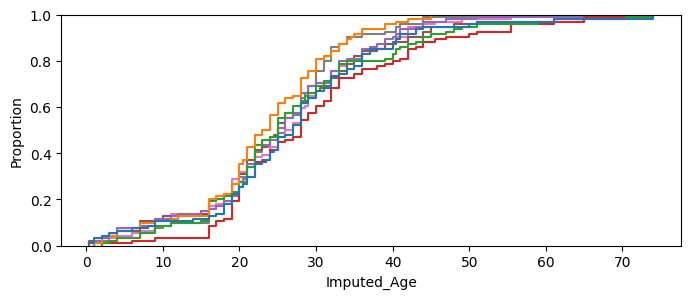

In [26]:
def plot_resampled_distributions(df, cols, ax):

    sns.ecdfplot(
        data = (
            df
            .query('Age.isna()')
            .filter(cols + ['PassengerId'])
            .melt(id_vars=['PassengerId'], value_name='Imputed_Age', var_name='ImputeIdx')
        ),
        x = 'Imputed_Age',
        hue = 'ImputeIdx',
        ax = ax,
        legend = False
    )

fig, axs = plt.subplots(1, 1, **{'figsize':(8,3)})

strat_resamp_cols = [c for c in train.columns if 'Age_S' in c]
plot_resampled_distributions(resamp_with_adj, strat_resamp_cols, axs)
plt.show()

### 2.4.2. Selecting donors based on distance
<span style="font-size:14px;font-family: Arial;line-height:1.5">
Creation of adjustment cells requires that we discretize continuous variables. In some cases this may be undersirable and we may instead want to identify donors based on their proximity to cases with missing data based on some distance in a space defined by features for which we have complete records.

In the titanic dataset, this could be for example based on the number of family members and the fare paid (here shown after log transform):
</span>

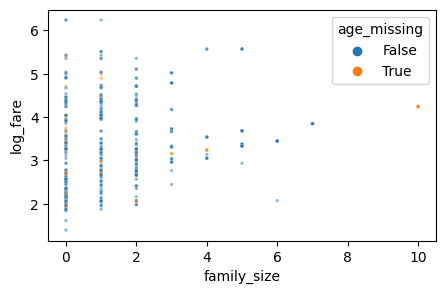

In [27]:
fig, ax = plt.subplots(1,1, **{'figsize':(5,3)})
sns.scatterplot(data=train, x='family_size', y='log_fare', hue='age_missing', s=6, alpha=0.5)
plt.show()

<span style="font-size:14px;font-family: Arial;line-height:1.5">
Within this space, we can define some neighbourhood either based on the K nearest neighbours (KNN) or some distance threshold.

In the plot above, the features happen to scale well relative to each other; however if we were to use the original fare values, distances would be dominated fares. It's therefore important to scale variables approapriately or use corrected distance metrics such as the Mahalanobis rather than Euclidean distance.

Note that if we were to sample from the K-nearest neighbours, this approach would differ from method used by the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer.fit_transform">K-nearest neighbour imputer in Sci-Kit Learn</a>, which computes the mean of the donor set and is thus deterministic (with the associated problems of underestimating sample variance). 

To accomodate the different strategies we could use for selecting donors (distance or KNN), we'll create a class that allows for random sampling using distance:
</span>

In [32]:
import numpy as np

class distance_sampler():

    def __init__(self, data:pd.DataFrame, var_to_impute:str, spatial_vars:List[str], n_impute):

        self.var_to_impute = var_to_impute      # name of column/feature that contains missing data
        self.spatial_vars = spatial_vars        # names of columns/features used to construct space in which to select donors
        self.n_impute = n_impute                # number of times to run imputation
        
        # Split input data into complete and partial cases
        self.complete_cases = data.dropna()
        self.partial_cases = data[data[var_to_impute].isna()]


    def impute_by_distance(self, distance_threshold:float):
        """ 
        To reduce time-complexity, we reduce the n
        """

        # Compute limits for each spatial dimension
        for dim in self.spatial_vars:
            self.partial_cases[f"{dim}_ub"] = self.partial_cases[dim] + distance_threshold      # upper bound
            self.partial_cases[f"{dim}_lb"] = self.partial_cases[dim] - distance_threshold      # lower bound 

        # For each partial case
        for case, case_data in partial_cases.iterrows():

            distances = complete_cases[spatial_vars].values - partial_cases[spatial_vars].values
            distances = np.linalg.norm(distances.astype(float), axis=1)

            donors = complete_cases[distance < distance_threshold]

        pass

    def impute_by_knn(self, k:int):
        """  """


array([[22.        ,  1.        ,  1.98100147],
       [38.        ,  1.        ,  4.26666208],
       [26.        ,  0.        ,  2.07002232],
       [35.        ,  1.        ,  3.97217693],
       [37.        ,  1.        ,  3.97217693],
       [35.        ,  0.        ,  2.08567209],
       [30.86808257,  0.        ,  2.13514821],
       [54.        ,  0.        ,  3.94859599],
       [ 2.        ,  4.        ,  3.0480875 ],
       [ 8.        ,  4.        ,  3.0480875 ]])

In [58]:
spatial_vars = ['log_fare', 'family_size']


temp = train.loc[:5,spatial_vars].values - train.loc[6, spatial_vars].values

distance = np.linalg.norm(temp.astype(float), axis=1)

In [66]:
np.where(distance < 1)

array([2, 5])

#### Imputation with weighting

In the case of Deck, we know that there are a limited number of decks for a given class (e.g. decks E to G for third class passengers). This means that we can use something about class to infer the deck on which a passenger was. However, passengers may not be equally distributed across decks - for example if deck E and F were shared with second class passengers. If we want to make a guess about which deck a passenger was staying, it would therefore be wise to take into account the relative probabilities of staying on each deck based on class. 

### 2.6.3. Hot Deck based on a matching metric
<span style="font-size:14px;font-family: Arial;line-height:1.5">
To impute missing Ages

1. Define a space from fully-observed metrics (e.g. a 1D space defined by Fare)
2. For each passenger with missing Age data:
    <br>i) measure the distance in that space to all other passengers with known Ages
    <br>ii) select passengers with known Ages within a specific distance (e.g. fares of ± £5)
    <br>iii) randomly sample an Age from within this selected group for use as imputed value

An advance on this is *predictive mean modelling* in which distances are based on predictions from a regression model

</span>

## 2.7. ML approaches
### 2.7.1. K-Nearest Neighbors Imputation

<span style="font-size:14px;font-family: Arial;line-height:1.5">
<p>
This involves using the values of the k-nearest neighbors to the missing data point to impute the missing value. This can be useful if the data is missing at random and if the missing data is similar to the values of its neighboring points. However, it can also introduce bias and error if the data is not missing at random or if the nearest neighbors are not representative of the missing data point.
</p><p>
These are just a few examples of methods for replacing missing data. There are many other methods and techniques that can be used, and the appropriate method to use depends on the specific context and characteristics of the missing data. It is important to carefully evaluate the missing data and consider the potential implications of different methods before deciding on a course of action.
</p></span>

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 3)

# Select columns to use for impute
columns_for_impute = ['Pclass','SibSp', 'Parch', 'Fare', 'gender_numeric', 'embarked_numeric','Age']

# Fit the imputer to the data
imputer.fit(train[columns_for_impute])

# Transform the data
imputed_data = imputer.transform(train[columns_for_impute])

# Create a new dataframe with the imputed data
imputed_df = pd.DataFrame(imputed_data, columns = columns_for_impute)

#### 2.3.2.5. Neural Networks

<span style="font-size:14px;font-family: Arial;line-height:1.5">
Given the hype, it's important to remember that a neural net isn't magic - it can't find relationships if they don't exist. Also, if those relationships are very complex, we may not have enough data to find them.
</span>

In [ ]:
from tensorflow import keras

# Create a sample dataset with missing values
data = np.array([[1, 2, np.nan],
                 [3, 4, 5],
                 [6, np.nan, 7],
                 [np.nan, 8, 9]])

# Define the model
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(3,)),
    keras.layers.Dense(10),
    keras.layers.Dense(3)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(data, data, epochs=100)

# Use the trained model to impute missing values
imputed_data = model.predict(data)

# Print the imputed dataset
print(imputed_data)

## 2.7 Graph-based methods

The methods above assume that the data is missing at random (MAR). Our initial inspection of the data in Section 2.2. indicated that there is some reason to believe this assumption as the obvious causes of missing data (e.g. sampling bias) are not immediately apparent. However if data is MNAR, then we need a method of modelling the missingness mechanism.

Graph based methods (reviewed in [Mohan and Pearl, 2021](https://www.tandfonline.com/doi/epdf/10.1080/01621459.2021.1874961?needAccess=true&role=button))

## 2.8. Cold Deck methods

Sampling from other datasets - e.g. census data, passenger information from other ships

## 2.9. Further Considerations

### 2.9.1. Documenting Missing Data

<span style="font-size:14px;font-family: Arial;line-height:1.5">
We began this chapter by discussing how to find missing data and think about the reasons why some datapoints might be absent. While the titanic dataset is useful for illustrating the general flow of data science workflows, it should be noted that it's best practice to document the sources and reasons for missing data at the point of data collection. 

</span>


### 2.9.2. Approaches that are robust to missing data

- Generalized linear mixed models
- XGBoost (Sparsity Aware Split Finding)

### 2.9.3. Preventing Data Leakage: Never merge the train and test data

<span style="font-size:14px;font-family: Arial;line-height:1.5">

When imputing missing data, one might think that we should combine data from the training and test datasets, so that we can maximise our ability to estimate missing values. However, if we were to merge the two datasets, we would potentially risk **data leakage** that might undermine the model we're training. 

A simple example using regression imputation shows you why: Here we simulate a simple experiment in which age is correlated with ticket fare, but the correlation coefficients and ranges of fares in test and train data are different:

### 2.9.4. Recoverability

Although we have spent this chapter thinking about how to recover missing data, one must acknowledge the possibility that no method exists that produces a consistent estimate of the lost data from complete cases. In such situations, one must instead model the process that causes missing data.

"Recoverability is a data-independent task that takes as input a pair, a query and a model, and determines if the value of the query can be estimated as sample size approaches infinity, assuming that only variables assigned R variables can be corrupted by missingness." (see Mohan & Pearl 2021 for discussion).

In general, we must have some complete cases for all combinations of variables in order for a graph to be recoverable.


### 2.9.5. Tension between statistics and machine learning 

There is much discussion about the conflicting demands between methods in statistics and machine learning (REFERENCE). Imputation is one example where this comes into play, as the goal of the kaggle competition - and machine learning approaches more broadly, is to find the best predictions of the missing values for the survival column.

However statisticians are more often interested in making inferences about population quantities such as means, correlations and regression coefficients. In such cases, "the objective of imputation is not to get the best possible predictions of the missing values, but to replace them by plausible values in order to exploit the information in the recorded variables in the incomplete cases for inference about population parameters" (Little & Rubin, 2002)

It may thus be inappropriate to compare predictive performance of imputation methods from statistics and machine learning, when statistical methods don't attempt to recover missing data at the level of individual units.


</span>

In [ ]:
import numpy as np

n_passengers, max_age = 200, 80

train_age = np.random.rand(n_passengers) * max_age
test_age = np.random.rand(n_passengers) * (max_age/2)              # test subjects are half as old 

train_fare = (train_age * 10) + (25*np.random.rand(n_passengers))   # y = a + bx + noise
test_fare = (test_age * 5) + (25*np.random.rand(n_passengers))      

# mask a subset of ages (data has no order)
proportion_missing = 0.3
train_age[:int(n_passengers*proportion_missing)] = np.nan   
fares_for_missing_data = train_fare[:int(n_passengers*proportion_missing)]

In [ ]:
# Impute values using linear regression with only training data
from sklearn.linear_model import LinearRegression

X = train_fare[~np.isnan(train_age)].reshape(-1,1)
y = train_age[~np.isnan(train_age)].reshape(-1,1)

training_only = LinearRegression().fit(X, y)
trained_only_prediction = training_only.predict(fares_for_missing_data.reshape(-1, 1))

In [ ]:
# Now impute values using linear regression on merged test and training data
X_merged = np.vstack((X, test_fare.reshape(-1, 1)))
y_merged = np.vstack((y, test_age.reshape(-1, 1)))

merged_model = LinearRegression().fit(X_merged, y_merged)
merged_prediction = merged_model.predict(fares_for_missing_data.reshape(-1,1))

<span style="font-size:14px;font-family: Arial;line-height:1.5">
When we plot the results in the cell below, we can see that the imputed ages of subjects is very strongly affected by the merging of train and test datasets. If we were then to build our survival model based on the ages imputed after merging, that model would also be influenced by the test data. In deployment, such a model may generalize poorly because it can no longer rely on the leaked information that allowed it to perform well on the test data.
</span>

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

plt.scatter(train_fare, train_age, marker='.', color='c', alpha=0.5, label='Train (Observed)')
plt.scatter(test_fare, test_age, marker='.', color='orange', alpha=0.5, label='Test (Observed)')

plt.scatter(
    train_fare[np.isnan(train_age)], 
    trained_only_prediction, 
    marker='x', s=5, color='b', label='Train (Imputed)')

plt.scatter(
    train_fare[np.isnan(train_age)], 
    merged_prediction, 
    marker='x', s=5, color='r', label='Merged (Imputed)')

plt.ylabel('Age (Years)')
plt.xlabel('Fare (£)')
plt.legend()
plt.show()



### 2.4.2. Multiple Imputation (MI)

In the statistics community, it is common practice to perform multiple imputations, generating, for example, *m* separate imputations for a single feature matrix. Each of these *m* imputations is then put through the subsequent analysis pipeline (e.g. feature engineering, clustering, regression, classification). The *m* final analysis results (e.g. held-out validation errors) allow the data scientist to obtain understanding of how analytic results may differ as a consequence of the inherent uncertainty caused by the missing values. 

One advantage of MI is that it allows us to compare models of missingness and see how sensitive our analysis is to our theories about why data is missing.

## 2.5. Final steps

When identifying and imputing missing data, we modified some columns for which we've already done feature engineering. We must remember to then update these columns in order to pass on the improvements.

In [ ]:

# Repeat the log transform from Chapter 1, but now zero values aren't a problem
import numpy as np

train['log_fare'] = np.log(train['Fare'])
test['log_fare'] = np.log(test['Fare'])

Check that we're no longer missing any values

In [ ]:
pd.concat([
    train.shape[0] - train.describe(include='all').head(1).rename({'count':'train'}),    
    test.shape[0] - test.describe(include='all').head(1).rename({'count':'test'})
])

## Conclusions


Need for multivariate imputation to preserve associations between missing variables

To map out the missing data, we will first consider the data in it's original form (i.e. before we did some simple feature engineering in Chapter 1).

### Python Packages

Imputation in python is available through several libraries, however some of these are still in development:

* [MIDASpy](https://github.com/MIDASverse/MIDASpy)
* [sklearn.impute](https://scikit-learn.org/stable/modules/impute.html) 
* [impyute](https://impyute.readthedocs.io/en/master/)



### R Packages

The R ecosystem also has some well developed packages for imputation:
* MICE (Multivariate Imputation via Chained Equations) 
* [rMIDAS](https://github.com/MIDASverse/rMIDAS)
* [Amelia](https://cran.r-project.org/web/packages/Amelia/index.html)
* missForest
* Hmisc
* mi


### Applications of Imputation beyond the Titanic

Recommendation systems

Imagine another universe in which the titanic didn't sink, and instead of survival values, we had ratings of how good the journey was. If we had those ratings for all the White Star line ships, then we could build a table of every passenger and every possible journey, with some data filled in for completed journeys and other data missing for possible trips in the future. Using imputation, we could fill in that missing data to predict passenger's ratings for those possible trips and then select those trips that are likely to be well rated. This is a **recommendation system** like those used in a variety of services (Netflix, Spotify etc.) and is based on the solution to an imputation problem of filling in missing data.